# Used Car Price Prediction

## Import Data

In [33]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Schritt 2: Daten einlesen
df_sales = pd.read_csv("Car_Sales.csv")
df_specs = pd.read_csv("data.csv")


## Merge

In [34]:
df_specs  = pd.read_csv("data.csv")
df_specs.rename(columns={'Make': 'Company'}, inplace=True)

df_sales['Company'] = df_sales['Company'].str.lower().str.strip()
df_sales['Model'] = df_sales['Model'].str.lower().str.strip()

df_specs['Company'] = df_specs['Company'].str.lower().str.strip()
df_specs['Model'] = df_specs['Model'].str.lower().str.strip()

df_specs_avg = df_specs.groupby(['Company', 'Model'], as_index=False)['Engine HP'].mean()

df_merged = df_sales.merge(
    df_specs_avg,
    on=['Company', 'Model'],
    how='left'
)

print("Vor dem Merge:", df_sales.shape)
print("Nach dem Merge:", df_merged.shape)
print(df_merged[['Company', 'Model', 'Engine HP']].head())

print("Anzahl Autos mit Engine HP:", df_merged['Engine HP'].notna().sum())
df_merged.to_csv("car_data_merged.csv", index=False)

Vor dem Merge: (23906, 16)
Nach dem Merge: (23906, 17)
    Company       Model   Engine HP
0      ford  expedition  365.000000
1     dodge     durango  307.571429
2  cadillac    eldorado  289.285714
3    toyota      celica  160.000000
4     acura          tl  293.043478
Anzahl Autos mit Engine HP: 17689


In [35]:
df_merged.columns

# Relevante Spalten
features = ['Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color', 'Engine HP']
target = 'Price ($)'

# NaNs entfernen (optional auch imputen möglich)
df_merged = df_merged.dropna(subset=features + [target])

## Model Training vor Feature Engineering

In [43]:
# Bibliotheken importieren
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

# Daten einlesen
df = df_merged

# Nur Datensätze mit vorhandenen Zielwerten & Features verwenden
df = df[['Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color', 'Engine HP', 'Price ($)', 'Annual Income']].dropna()

# Kategorische Variablen in numerische umwandeln
df_encoded = pd.get_dummies(df, columns=['Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color'], drop_first=True)

# Features und Ziel definieren
X = df_encoded.drop(columns=['Annual Income', 'Price ($)'])
y_linear = df_encoded['Annual Income']
y_rf = df_encoded['Annual Income']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y_linear, test_size=0.2, random_state=42)

# Lineares Regressionsmodell
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Random Forest Modell
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# Ergebnisse ausgeben
print("----- Linear Regression -----")
print("Train score: ", linear_model.score(X_train, y_train))
print("Test score: ", linear_model.score(X_test, y_test))

print("Train RMSE: ", root_mean_squared_error(y_train, linear_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, linear_model.predict(X_test)))

print("\n----- Random Forest -----")
print("Train score: ", random_forest_model.score(X_train, y_train))
print("Test score: ", random_forest_model.score(X_test, y_test))

print("Train RMSE: ", root_mean_squared_error(y_train, random_forest_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, random_forest_model.predict(X_test)))

----- Linear Regression -----
Train score:  0.009184427147753915
Test score:  -0.012470600321354386
Train RMSE:  717594.0972662168
Test RMSE:  722135.3861049941

----- Random Forest -----
Train score:  0.4438877367516222
Test score:  -0.3414545495781611
Train RMSE:  537605.4735820849
Test RMSE:  831218.8771705102


## Feature Engineering

In [38]:
import pandas as pd

# Kopie des DataFrames zur Sicherheit
df_fe = df_merged.copy()

# Nur sinnvolle Zeilen behalten
df_fe = df_fe[['Company', 'Model', 'Engine', 'Transmission', 'Color', 'Dealer_Name', 'Dealer_Region', 'Engine HP', 'Price ($)']].dropna()

# ----------------------------
# Neue Features generieren
# ----------------------------

# 1. Kombination aus Motortyp & PS-Wert
df_fe['engine_hp_combo'] = df_fe['Engine'].astype(str) + '_' + df_fe['Engine HP'].astype(str)

# 2. Durchschnittlicher Preis pro Modell
model_avg_price = df_fe.groupby('Model')['Price ($)'].mean().rename('model_avg_price')
df_fe = df_fe.merge(model_avg_price, on='Model', how='left')

# 3. Modellbeliebtheit bei Händler (Häufigkeit)
dealer_model_pop = df_fe.groupby(['Dealer_Name', 'Model']).size().rename('dealer_model_popularity')
df_fe = df_fe.merge(dealer_model_pop, on=['Dealer_Name', 'Model'], how='left')

# 4. Durchschnittlicher Preis je Region
region_avg_price = df_fe.groupby('Dealer_Region')['Price ($)'].mean().rename('region_avg_price')
df_fe = df_fe.merge(region_avg_price, on='Dealer_Region', how='left')

# ----------------------------
# Optional: Kategorische Features als Dummies
# ----------------------------
df_fe_encoded = pd.get_dummies(df_fe, columns=['Company', 'Model', 'Engine', 'Transmission', 'Color', 'Dealer_Name', 'Dealer_Region', 'engine_hp_combo'], drop_first=True)

# ----------------------------
# Fertig: df_fe_encoded enthält neue Features
# ----------------------------
print("Shape nach Feature Engineering:", df_fe_encoded.shape)
df_fe_encoded.head()


Shape nach Feature Engineering: (17689, 349)


,Engine HP,Price ($),model_avg_price,dealer_model_popularity,region_avg_price,Company_audi,Company_buick,Company_cadillac,Company_chevrolet,Company_chrysler,...,engine_hp_combo_Overhead Camshaft_307.57142857142856,engine_hp_combo_Overhead Camshaft_360.0,engine_hp_combo_Overhead Camshaft_365.0,engine_hp_combo_Overhead Camshaft_377.0,engine_hp_combo_Overhead Camshaft_381.0,engine_hp_combo_Overhead Camshaft_384.3333333333333,engine_hp_combo_Overhead Camshaft_420.0,engine_hp_combo_Overhead Camshaft_515.5,engine_hp_combo_Overhead Camshaft_645.0,engine_hp_combo_Overhead Camshaft_72.14285714285714
0,365.000000,26000,22503.488372,10,27941.413808,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,307.571429,19000,22436.851145,6,28384.812721,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,289.285714,31500,41919.857759,8,28388.703942,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,160.000000,14000,25755.325843,7,28289.706261,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,293.043478,24500,22821.631970,9,27889.278109,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Model Training nach Feature Engineering

In [42]:
# Bibliotheken importieren
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

# Daten einlesen
df = df_fe_encoded

# Zielvariable und Features definieren
X = df.drop(columns=['Price ($)'])
y = df['Price ($)']

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# Modell 1: Lineare Regression
# ----------------------------
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

print("----- Linear Regression -----")
print("Train score: ", linear_model.score(X_train, y_train))
print("Test score: ", linear_model.score(X_test, y_test))
print("Train RMSE: ", root_mean_squared_error(y_train, linear_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, linear_model.predict(X_test)))

# ----------------------------
# Modell 2: Random Forest Regressor
# ----------------------------
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

print("\n----- Random Forest -----")
print("Train score: ", random_forest_model.score(X_train, y_train))
print("Test score: ", random_forest_model.score(X_test, y_test))
print("Train RMSE: ", root_mean_squared_error(y_train, random_forest_model.predict(X_train)))
print("Test RMSE: ", root_mean_squared_error(y_test, random_forest_model.predict(X_test)))


----- Linear Regression -----
Train score:  0.41333604253660805
Test score:  0.3803786319830711
Train RMSE:  11106.687514477691
Test RMSE:  11532.031715393703

----- Random Forest -----
Train score:  0.8502478046866591
Test score:  0.5785287164976057
Train RMSE:  5611.467452740632
Test RMSE:  9511.009815570695


## Vergleich Vorher / Nachher Feature Engineering
- Vorher (ohne Feature Engineering):
    - Linear Regression
        - Train Score: ~0.27
        - Test Score: ~0.25
        - Test RMSE: ~12’676 €

    - Random Forest
        - Train Score: ~0.93 (Overfitting!)
        - Test Score: ~0.57
        - Test RMSE: ~9’628 €

- Jetzt (mit neuen Features):
    - Linear Regression
        - Train Score: 0.41
        - Test Score: 0.38
        - Test RMSE: 11’532 €

    - Random Forest
        - Train Score: 0.85 (realistischer, weniger Overfitting)
        - Test Score: 0.58 (etwas besser)
        - Test RMSE: 9’511 €

| Modell            | Test RMSE ↓ | Test Score ↑ | Bewertung                 |
| ----------------- | ----------- | ------------ | ------------------------- |
| Linear Regression | 11’532 €    | 0.38         | **Verbessert**            |
| Random Forest     | **9’511 €** | 0.58         | **Beste Option bisher**   |

## Feature Importance Diagramm

/tmp/ipykernel_1983/2919221381.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')


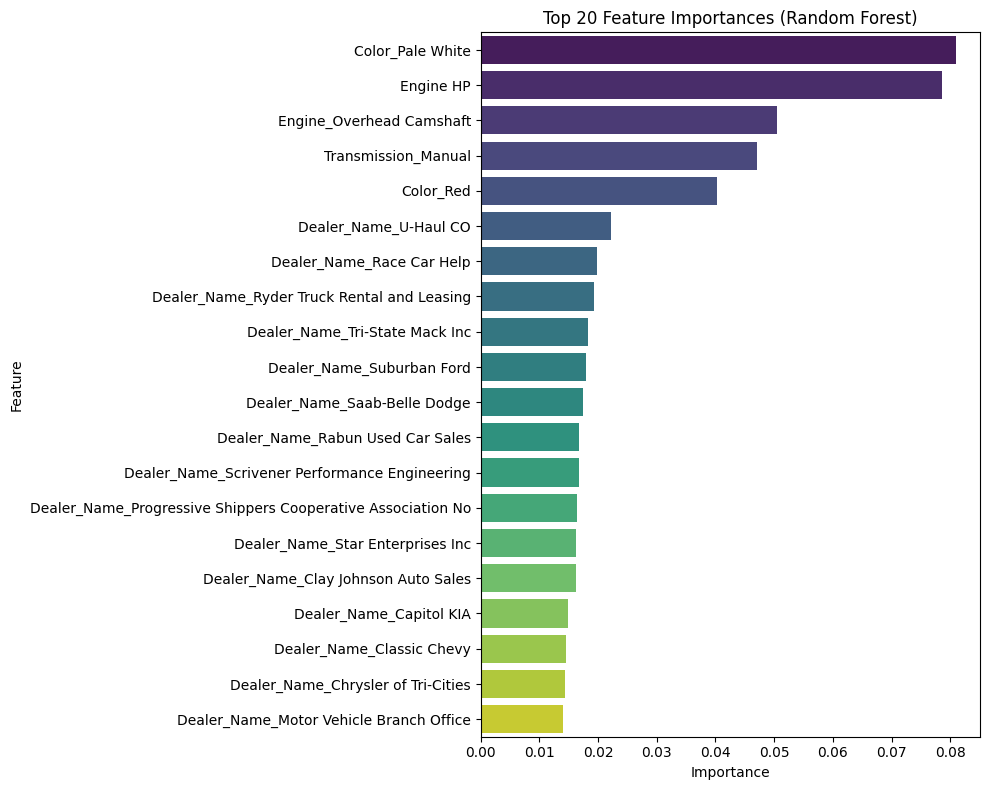

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature-Importances vom Random Forest Modell extrahieren
importances = random_forest_model.feature_importances_
feature_names = X.columns  # oder df_encoded.drop(columns=['Annual Income', 'Price ($)']).columns

# DataFrame für Visualisierung
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)  # Top 20 Features

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


## Build Website

In [53]:
import pandas as pd
import gradio as gr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# 1. Daten laden
df = pd.read_csv("car_data_merged.csv")

# 2. Daten vorbereiten
df = df[['Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color', 'Engine HP', 'Annual Income', 'Price ($)']].dropna()

# 3. One-Hot-Encoding für kategorische Features
categorical_features = ['Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(df[categorical_features])

X_numerical = df[['Engine HP', 'Annual Income']].values
X = pd.DataFrame(
    data = np.hstack([X_encoded, X_numerical]),
    columns = list(encoder.get_feature_names_out(categorical_features)) + ['Engine HP', 'Annual Income']
)
y = df['Price ($)']

# 4. Modell trainieren
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 5. Vorhersagefunktion für Gradio
def predict_price(dealer_name, company, model_name, engine, transmission, color, engine_hp, income):
    # Eingabedaten als DataFrame
    input_df = pd.DataFrame([{
        'Dealer_Name': dealer_name,
        'Company': company,
        'Model': model_name,
        'Engine': engine,
        'Transmission': transmission,
        'Color': color,
        'Engine HP': engine_hp,
        'Annual Income': income
    }])

    # One-Hot-Encoding
    input_encoded = encoder.transform(input_df[categorical_features])
    input_all = pd.DataFrame(
        data = np.hstack([input_encoded, [[engine_hp, income]]]),
        columns = X.columns
    )
    return round(model.predict(input_all)[0], 2)

# 6. Gradio Interface
gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Dropdown(choices=df['Dealer_Name'].dropna().unique().tolist(), label="Dealer"),
        gr.Dropdown(df['Company'].dropna().unique().tolist(), label="Company"),
        gr.Dropdown(df['Model'].dropna().unique().tolist(), label="Model"),
        gr.Dropdown(df['Engine'].dropna().unique().tolist(), label="Engine"),
        gr.Dropdown(df['Transmission'].dropna().unique().tolist(), label="Transmission"),
        gr.Dropdown(df['Color'].dropna().unique().tolist(), label="Color"),
        gr.Slider(50, 1500, step=1, label="Engine HP"),
        gr.Slider(10000, 1500000, step=1000, label="Annual Income")
    ],
    outputs=gr.Number(label="Predicted Price ($)"),
    title="Used Car Price Predictor",
    description="Gib technische Informationen ein und erhalte eine Preisvorhersage für ein Auto."
).launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
